## Equivariant Hybrid Quantum Neural Network Model


In this notebook we implement the equivariant hybrid model which consists of a quantum layer and a classical dense layer. It's capable to perform binary classification.
We have a package called Equivariant_QCNN where we can call different hybrid models and load the preprocessed data.



In [1]:
import sys
import os

# add the main directory to the notebook
sys.path.append(os.path.abspath(os.path.join('/home/lazaror/quantum/pruebas/EQCNN_local_testing/EQNN_for_HEP')))

import numpy as np
from Equivariant_QCNN.data.hybrid_data import load_hybrid_data
from Equivariant_QCNN.models.hybrid_models import *
import matplotlib.pyplot as plt

First, we call the hybrid model using the *hybrid_models* function which has two parameters: 
- model. It can be 0 for equivariant model (quantum layer + dense layer), 1 for hybrid model (using dense layer + quantum layer + dense layer) and 2 for hybrid model (quantum layer + dense layer). 
- num_layers. This refers to the number of layers in the quantum circuit.

Those models are designed to run with images of 16x16x1 dimensions.

In [2]:
equiv_model = hybrid_models(model = 0, num_layers= 4)
equiv_model

Sequential(
  (0): <Quantum Torch Layer: func=hybrid_circuit>
  (1): Linear(in_features=16, out_features=2, bias=True)
  (2): Softmax(dim=1)
)

Now, we load the dataset already preprocessed using the *load_hybrid_data*. The arguments are the following: 
- dataset: [str] It can be "mnist", "fashion_mnist", "quark_gluon", "electron_photon"
- train_size: [int] It refers the number of data that we want in the train dataset.
- test_size: [int] It refers to the number of data in the test dataset.  
- classes: [ list of two integers i.e. [0,1]  ] It refers to the classes to be loaded. 

In [3]:
dataset = "mnist"
train_size = 10000
test_size = 2000
X_train, y_train, X_test, y_test = load_hybrid_data(dataset, train_size, test_size, classes = [0,1])

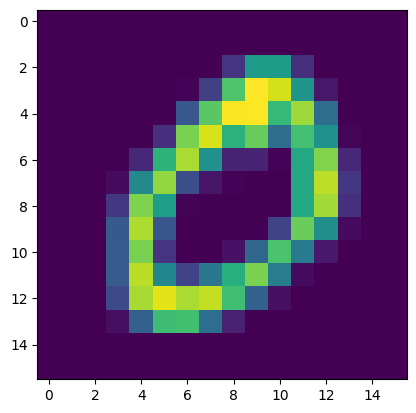

In [4]:
plt.imshow(X_train[0])
plt.show()

To train the hybrid model we use the *training_hybrid* function which has the following parameters: 
- X_train: training dataset corresponding to the independent data. 
- y_train: training dataset corresponding to the dependent data. (labels)
- epochs: number of epochs for the training.
- batch_size: number of data in each batch during the training. 
- samples: if we want to use less data that original training.
- model: It can be 0 for equivariant model (quantum layer + dense layer), 1 for hybrid model (using dense layer + quantum layer + dense layer) and 2 for hybrid model (quantum layer + dense layer). 
- num_layers: number of quantum layers in the model. 


In [9]:
trained_model, loss_history = training_hybrid(X_train, y_train, epochs = 50, batch_size= 64, samples= 10000, model = 0, num_layers = 4)

Average loss over epoch 1: 0.4959
Average loss over epoch 2: 0.4849
Average loss over epoch 3: 0.4775
Average loss over epoch 4: 0.4727
Average loss over epoch 5: 0.4692
Average loss over epoch 6: 0.4669
Average loss over epoch 7: 0.4643
Average loss over epoch 8: 0.4615
Average loss over epoch 9: 0.4571
Average loss over epoch 10: 0.4488
Average loss over epoch 11: 0.4300
Average loss over epoch 12: 0.3924
Average loss over epoch 13: 0.3485
Average loss over epoch 14: 0.3105
Average loss over epoch 15: 0.2782
Average loss over epoch 16: 0.2508
Average loss over epoch 17: 0.2279
Average loss over epoch 18: 0.2084
Average loss over epoch 19: 0.1920
Average loss over epoch 20: 0.1779
Average loss over epoch 21: 0.1658
Average loss over epoch 22: 0.1554
Average loss over epoch 23: 0.1462
Average loss over epoch 24: 0.1382
Average loss over epoch 25: 0.1311
Average loss over epoch 26: 0.1247
Average loss over epoch 27: 0.1190
Average loss over epoch 28: 0.1139
Average loss over epoch 29: 0

Confusion matrix

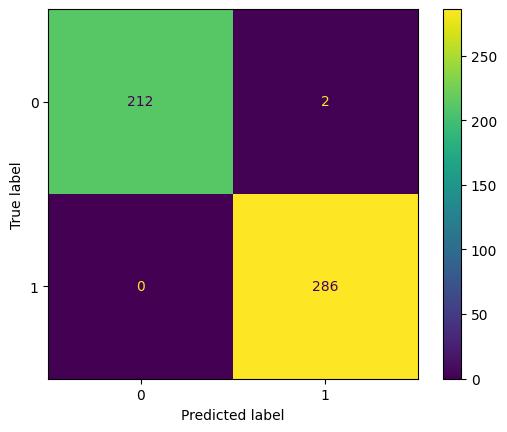

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

samples = 500
X_test = X_test[:samples].reshape(samples, 16*16).float().requires_grad_(True)

y_pred = trained_model(X_test)
_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

cm = confusion_matrix(y_test[:samples], y_pred_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

Accuracy

In [10]:
y_pred = trained_model(X_test)

_, y_pred_classes = torch.max(y_pred, dim=1)
y_pred_classes = y_pred_classes.detach().numpy()

correct = (y_pred_classes == y_test[:samples].numpy()).sum()
accuracy = correct / len(y_test[:samples])
print(f"Accuracy: {accuracy * 100}%")

Accuracy: 99.6%


Proof of equivariance

/tmp/ipykernel_1104447/2160176878.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  matrix_tensor = torch.tensor(matrix.reshape(1, 16*16), dtype=torch.float32)  # Convert the original image


Output with probabilities for the original image: tensor([[0.3875, 0.6125]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the Y-axis: tensor([[0.3875, 0.6125]], grad_fn=<SoftmaxBackward0>)
Output with probabilities for the image reflected over the X-axis: tensor([[0.3875, 0.6125]], grad_fn=<SoftmaxBackward0>)


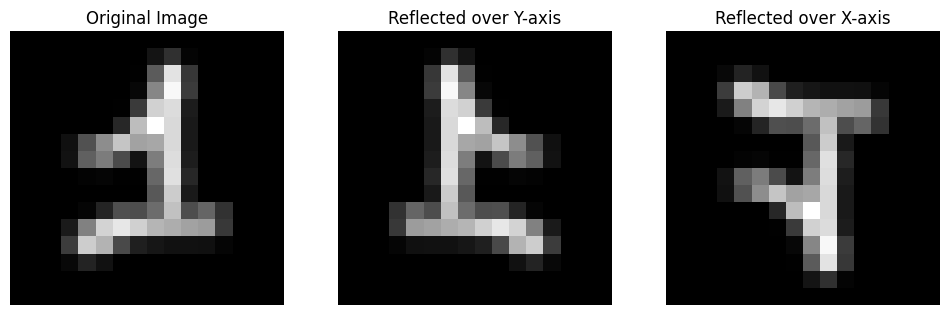

In [16]:
matrix = X_train[7]

# Reflect the image over the Y-axis
matrix_reflected_y = np.fliplr(matrix)

# Reflect the image over the X-axis
matrix_reflected_x = np.flipud(matrix)

# Convert NumPy arrays to PyTorch tensors
matrix_tensor = torch.tensor(matrix.reshape(1, 16*16), dtype=torch.float32)  # Convert the original image
matrix_reflected_y_tensor = torch.tensor(matrix_reflected_y.reshape(1, 16*16), dtype=torch.float32)  # Reflected over Y
matrix_reflected_x_tensor = torch.tensor(matrix_reflected_x.reshape(1, 16*16), dtype=torch.float32)  # Reflected over X

# Pass the tensors to the model
result1 = trained_model(matrix_tensor)
result2 = trained_model(matrix_reflected_y_tensor)
result3 = trained_model(matrix_reflected_x_tensor)

# Display the results
print(f"Output with probabilities for the original image: {result1}")
print(f"Output with probabilities for the image reflected over the Y-axis: {result2}")
print(f"Output with probabilities for the image reflected over the X-axis: {result3}")

# Plot the images in a single row
fig, axes = plt.subplots(1, 3, figsize=(12, 4))  # 1 row, 3 columns, adjustable size

# Show the original image
axes[0].imshow(matrix, cmap='gray')
axes[0].set_title("Original Image")
axes[0].axis('off')

# Show the image reflected over the Y-axis
axes[1].imshow(matrix_reflected_y, cmap='gray')
axes[1].set_title("Reflected over Y-axis")
axes[1].axis('off')

# Show the image reflected over the X-axis
axes[2].imshow(matrix_reflected_x, cmap='gray')
axes[2].set_title("Reflected over X-axis")
axes[2].axis('off')

# Display the images
plt.show()

As we can see, the output is the same for the original image and the reflected images. This ensure invariance under reflection symmetry.